#  Task 2: Extract prevalent topics from Twitter messages

## 🎯 Objective

- The goal of this project is to **extract the most frequent topics** discussed in tweets related to a specific city or region using **Natural Language Processing (NLP)** techniques.
- This analysis helps identify **trends, public concerns, and popular discussions** by processing tweet content.
- The insights can support **local researchers, journalists, or policymakers** by showing what people are actively talking about in a particular location.

## Diagram of the project

![ScholarAI Diagram](https://i.postimg.cc/K8nDNHt5/Diagram-4.png)

# Notebook Installations

In [1]:
!pip install -qU tweepy

In [2]:
!pip install -qU bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the

In [3]:
!pip install -qU langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
!pip install -qU pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 49.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [5]:
import tweepy
import time
import pandas as pd
import re
from kaggle_secrets import UserSecretsClient
from wordcloud import WordCloud


# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

from IPython.display import HTML
import pandas as pd
from tweepy.errors import TooManyRequests
import pandas as pd
from IPython.display import HTML

import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic
from collections import Counter

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from langdetect import detect

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc

2025-05-22 11:53:49.748521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747914829.983806      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747914830.049573      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Step 1: Data Collection

Due to limitations with the Twitter API, which only allows scraping a small number of tweets (up to 100), I opted to use an open-source dataset from Kaggle: [2024 US Presidential Elections Twitter Data](https://www.kaggle.com/datasets/rohanroy1/2024-us-presidential-elections-twitter-data). The dataset contains 25,652 tweets related to the upcoming U.S. presidential election. This allowed me to conduct a large-scale topic analysis without incurring API access costs or limitations.

In [7]:
df = pd.read_csv("/kaggle/input/2024-us-presidential-elections-twitter-data/final_raw.csv")
print(df.head())

              Tweet ID            Username  \
0  1798142586911342936          Rabbit1873   
1  1798142575112769914      Chrissi Miller   
2  1798142544762830918  Pedro Da Conceicao   
3  1798142432388714849              Ben 🇺🇲   
4  1798142320958943735  🇺🇸Proud American🇮🇹   

                                                Text  \
0  @JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...   
1  @PaulStanleyLive #PresidentDonaldTrump wins th...   
2  @tomorrowsmps I believe I am the youngest PPC ...   
3  I am already saying Democrats will cheat even ...   
4  @BryanDeanWright Republican AG’s should prosec...   

                             Date  Retweets  Likes    Weight  
0  Tue Jun 04 23:59:35 +0000 2024         2      3  0.622459  
1  Tue Jun 04 23:59:32 +0000 2024         0      0  0.622459  
2  Tue Jun 04 23:59:25 +0000 2024         0      0  0.982014  
3  Tue Jun 04 23:58:58 +0000 2024         0      0  0.500000  
4  Tue Jun 04 23:58:31 +0000 2024         0      2  0.880797  


In [8]:
df.shape

(26425, 7)

In [9]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


In [10]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
Tweet ID    0
Username    2
Text        0
Date        0
Retweets    0
Likes       0
Weight      0
dtype: int64


In [11]:
print(f"The types of the data: \n{df.dtypes}\n")

The types of the data: 
Tweet ID      int64
Username     object
Text         object
Date         object
Retweets      int64
Likes         int64
Weight      float64
dtype: object



In [12]:
df.drop_duplicates('Text', inplace=True)
print(df.shape)
df.head()

(26314, 7)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797


# Step 2: Data Preprocessing


* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.


In [13]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [14]:
df['Language'] = df['Text'].apply(lambda x: detect_lang(x))
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [15]:
df['Language'].value_counts()

Language
en         24612
es           182
de           181
nl           135
id           133
fr           108
af            93
pt            82
no            72
ro            68
fi            61
it            55
et            53
tr            44
tl            43
ca            42
da            36
unknown       30
so            30
sv            28
sw            28
sl            26
vi            25
pl            23
cy            19
ja            17
lt            14
hr            13
hu            13
sq             9
sk             9
zh-cn          8
cs             6
fa             3
ar             3
lv             3
hi             2
ur             2
uk             1
he             1
ko             1
Name: count, dtype: int64

In [16]:
df = df[df['Language'] == 'en'].reset_index(drop=True)
print(df.shape)
df.head()

(24612, 8)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [17]:
def clean_for_bertopic(text):
    """
    Lightly clean tweets for BERTopic (BERT-based models).
    Preserves stopwords and sentence structure for semantic understanding.

    Removes: HTML tags, URLs, mentions, hashtag symbols.
    """
    import re

    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#", '', text)  # Remove hashtag symbol only
    return text.strip().lower()

In [18]:
def clean_for_lda(text, wl=WordNetLemmatizer(), 
                  stop_words=set(stopwords.words('english') + ['http', 'https', 'amp', 'com'])):
    """
    Clean tweets for LDA/NMF topic modeling by removing noise and reducing words to their root form.

    Steps:
    - Remove HTML, URLs, mentions, hashtags
    - Lowercase
    - Tokenize
    - Remove stopwords and non-alphabetic tokens
    - Lemmatize
    """
    import re
    from nltk.tokenize import word_tokenize

    # Remove HTML, links, mentions, hashtag symbols
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#", '', text)

    # Tokenize and clean
    words = word_tokenize(text.lower())
    filtered_words = [wl.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]

    return ' '.join(filtered_words)

In [19]:
print(df.columns)

Index(['Tweet ID', 'Username', 'Text', 'Date', 'Retweets', 'Likes', 'Weight',
       'Language'],
      dtype='object')


In [20]:
df.head()

,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en


In [21]:
%%time
# For BERTopic
df['CleanText_BERT'] = df['Text'].astype(str).apply(clean_for_bertopic)

# For LDA
df['CleanText_LDA'] = df['Text'].astype(str).apply(clean_for_lda)

CPU times: user 9.04 s, sys: 379 ms, total: 9.42 s
Wall time: 9.44 s


In [22]:
df.drop_duplicates('CleanText_BERT', inplace=True) 
df.drop_duplicates('CleanText_LDA', inplace=True) 
df.reset_index(drop=True, inplace=True)

In [23]:
print(df.shape)
df.head()

(23688, 10)


,Tweet ID,Username,Text,Date,Retweets,Likes,Weight,Language,CleanText_BERT,CleanText_LDA
0,1798142586911342936,Rabbit1873,@JackPosobiec Re: BREAKING: GARLAND TO LAUNCH ...,Tue Jun 04 23:59:35 +0000 2024,2,3,0.622459,en,re: breaking: garland to launch 'election thre...,breaking garland launch threat task force go a...
1,1798142575112769914,Chrissi Miller,@PaulStanleyLive #PresidentDonaldTrump wins th...,Tue Jun 04 23:59:32 +0000 2024,0,0,0.622459,en,presidentdonaldtrump wins the presidential ele...,presidentdonaldtrump win presidential election
2,1798142544762830918,Pedro Da Conceicao,@tomorrowsmps I believe I am the youngest PPC ...,Tue Jun 04 23:59:25 +0000 2024,0,0,0.982014,en,i believe i am the youngest ppc standing in th...,believe youngest ppc standing election
3,1798142432388714849,Ben 🇺🇲,I am already saying Democrats will cheat even ...,Tue Jun 04 23:58:58 +0000 2024,0,0,0.500000,en,i am already saying democrats will cheat even ...,already saying democrat cheat even keep beggin...
4,1798142320958943735,🇺🇸Proud American🇮🇹,@BryanDeanWright Republican AG’s should prosec...,Tue Jun 04 23:58:31 +0000 2024,0,2,0.880797,en,republican ag’s should prosecute the 51 intell...,republican ag prosecute intelligence official ...


# **Step 3: Entity Analysis**

* **Hashtag**: Extracted all words starting with #, counted their frequency, and visualized the top 10 most used hashtags.
* **Mentions:** Extracted all mentions (@username) from tweet text, counted their occurrences, and visualized the top 10 most mentioned users.
* **Active Users:** Identified tweet authors from the Username field, ranked users by number of tweets, and plotted the top 10 most active users.
* **Common Words in Tweets**: Counted the most frequently used words across all tweets (after cleaning) to get a sense of the general vocabulary and discussion focus. This helped confirm the dataset’s strong focus on political events, candidates, and public concerns.

### Hashtags

In [24]:
# function to print all the hashtags in a text
def extract_hashtags(text):
    return [word[1:] for word in text.split() if word.startswith('#')]

In [25]:
hashtag_list = []
for i in range(len(df['Text'])):
    hashtags = extract_hashtags(df['Text'][i])
    if len(hashtags) != 0:
        hashtag_list.append(hashtags)

hashtag_list[:5]

[['PresidentDonaldTrump'],
 ['मोदी_चूरचूर_लड्डू'],
 ['GoogleAlerts'],
 ['GoogleAlerts'],
 ['GoogleAlerts']]

In [26]:
# flatten the list of hashtag lists
flat_hashtag_list = [hashtag.lower() for sublist in hashtag_list for hashtag in sublist]

# count the hashtags
hashtag_counts = Counter(flat_hashtag_list)

# get the top 10 most common hashtags
top_10_hashtags = hashtag_counts.most_common(10)

for tag, count in top_10_hashtags:
    print(f"#{tag}: {count}")

#trump: 99
#maga: 78
#trump2024: 69
#smartnews: 43
#kamalaharris: 39
#election2024: 38
#donaldtrump: 37
#biden: 35
#election: 25
#harriswalz2024: 23


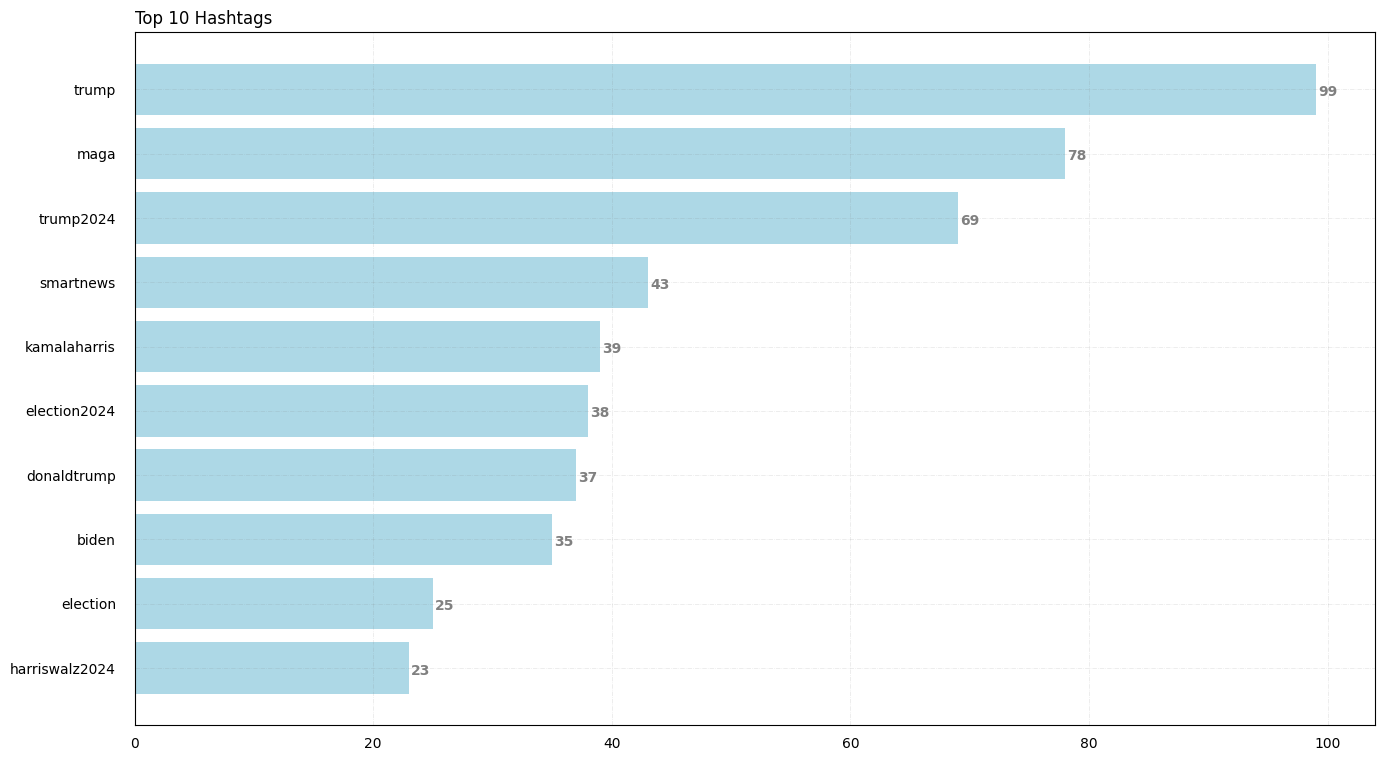

In [27]:
hashtags = [top_10_hashtags[i][0] for i in range(len(top_10_hashtags))]
count_hashtags = [top_10_hashtags[i][1] for i in range(len(top_10_hashtags))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(hashtags, count_hashtags, color='lightblue')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Hashtags', loc='left')

# Show Plot
plt.show()

### Mentions

In [28]:
# function to print all the users mentioned in a tweet
def extract_users(text):
    return [word[1:] for word in text.split() if word.startswith('@')]

In [29]:
users = [extract_users(text) for text in df['Text'] if extract_users(text)]
users[:5]

[['JackPosobiec'],
 ['PaulStanleyLive'],
 ['tomorrowsmps'],
 ['BryanDeanWright'],
 ['WashTimes']]

In [30]:
# flatten the list of users
flat_users_list = [user.lower() for sublist in users for user in sublist]

# count the users
user_counts = Counter(flat_users_list)

# get the top 10 most common users
top_10_users = user_counts.most_common(10)

for mentions, count in top_10_users:
    print(f"@{mentions}: {count}")

@mike_pence: 660
@youtube: 457
@elonmusk: 359
@kamalaharris: 335
@realdonaldtrump: 335
@robertkennedyjr: 254
@harris_wins: 180
@vivekgramaswamy: 155
@gunthereagleman: 143
@jdvance: 142


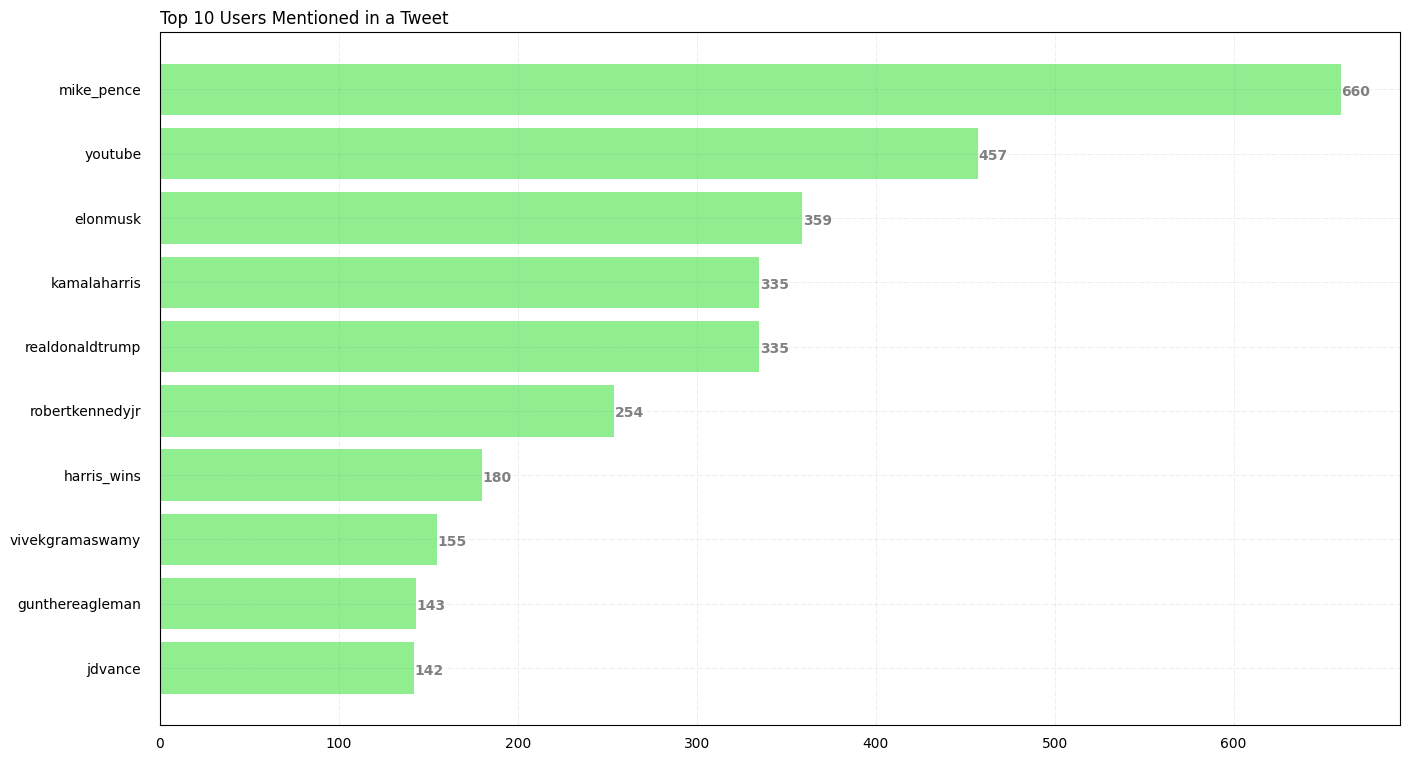

In [31]:
users = [top_10_users[i][0] for i in range(len(top_10_users))]
count_users = [top_10_users[i][1] for i in range(len(top_10_users))]

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

# Horizontal Bar Plot
ax.barh(users, count_users, color='lightgreen')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top 10 Users Mentioned in a Tweet', loc='left')

# Show Plot
plt.show()

### Active Users

In [32]:
df['Username'].value_counts()[:10]

Username
Vivek G. Ramaswamy - Commentary News    112
HaleyFan 🇵🇸                              81
RFK Jr's brain worm 🪱                    72
Mike Pence's Other Mother 🟧🟦🟪            49
Vivek Ramaswamy                          48
Richard Smit 🦅🚁💰🇳🇱🇺🇸🇬🇧🇮🇱🇺🇦🇹🇼             28
MA for RFK Jr                            27
Mike                                     25
Bulldogs4VivekOhio                       23
South Dakotans for RFK Jr                20
Name: count, dtype: int64

In [33]:
usernames = df['Username'].value_counts().index.tolist()
count_usernames = df['Username'].value_counts().values.tolist()

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

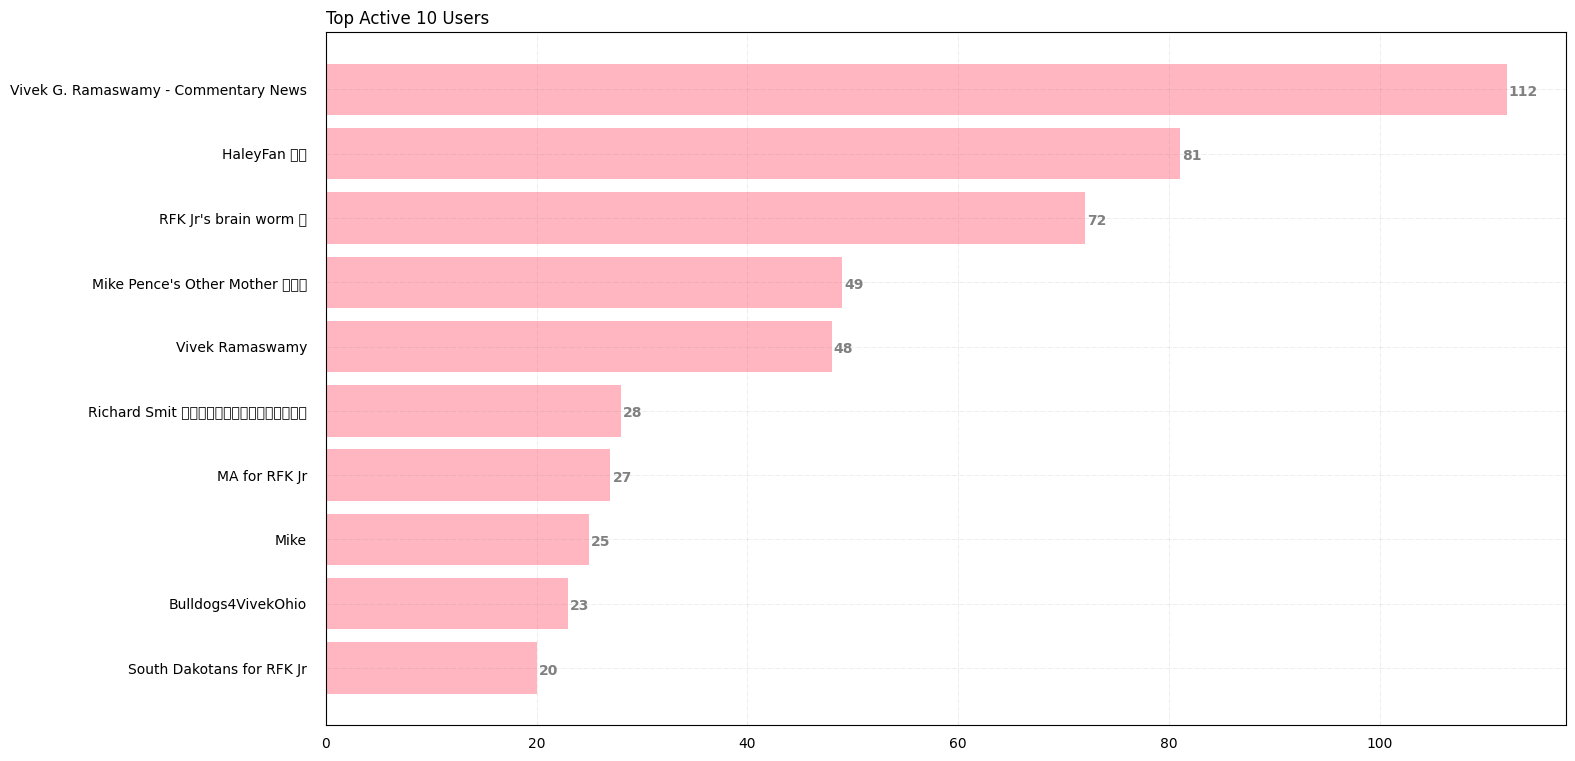

In [35]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))
plt.rcParams['font.family'] = 'DejaVu Sans'

# Horizontal Bar Plot
ax.barh(usernames[:10], count_usernames[:10], color='lightpink')

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(visible=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Top Active 10 Users', loc='left')

# Show Plot
plt.show()

### Common Words in Tweets

In [36]:
tweets = df['CleanText_LDA'].dropna().tolist()
long_string = ','.join(tweets)

In [37]:
len(long_string)

2111748

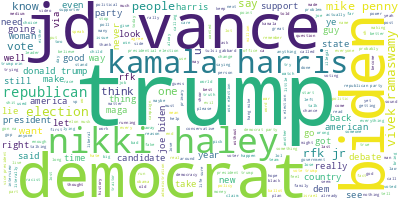

In [38]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=5, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [39]:
# count the words
word_counts = Counter(long_string.split())

# get the top 10 most common hashtags
top_10_words = word_counts.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

trump: 6785
election: 3191
biden: 3056
harris: 2689
democrat: 2546
republican: 2531
vance: 2455
kamala: 2399
rfk: 2039
haley: 2027


# Step 4: Topic Modeling

To extract meaningful themes from the tweets, I applied two different topic modeling techniques for comparison.


## Option 1: BERTopic Technique
BERTopic is a modern NLP technique that uses BERT embeddings for semantic understanding, UMAP for dimensionality reduction, HDBSCAN for clustering, and class-based TF-IDF (c-TF-IDF) for keyword extraction. 
- I used the `'all-MiniLM-L6-v2'` model for fast and accurate embeddings.
- The final model identified 48 topics, which I reduced to 12 more interpretable themes.
- A coherence score of **0.516** confirmed the quality of the topics.

In [40]:
df.columns

Index(['Tweet ID', 'Username', 'Text', 'Date', 'Retweets', 'Likes', 'Weight',
       'Language', 'CleanText_BERT', 'CleanText_LDA'],
      dtype='object')

In [41]:
df.drop(['Tweet ID', 'Text', 'Date', 'Retweets', 'Likes', 'Weight', 'Language'], axis=1, inplace=True)
df.head()

,Username,CleanText_BERT,CleanText_LDA
0,Rabbit1873,re: breaking: garland to launch 'election thre...,breaking garland launch threat task force go a...
1,Chrissi Miller,presidentdonaldtrump wins the presidential ele...,presidentdonaldtrump win presidential election
2,Pedro Da Conceicao,i believe i am the youngest ppc standing in th...,believe youngest ppc standing election
3,Ben 🇺🇲,i am already saying democrats will cheat even ...,already saying democrat cheat even keep beggin...
4,🇺🇸Proud American🇮🇹,republican ag’s should prosecute the 51 intell...,republican ag prosecute intelligence official ...


In [42]:
tweets = df['CleanText_BERT'].dropna().tolist()
tweets[:10]

["re: breaking: garland to launch 'election threat task force' to go after anyone questioning election integrity in 2024   he will create fbi attack teams...  fbi = gestapo",
 'presidentdonaldtrump wins the presidential election in 2024',
 'i believe i am the youngest ppc standing in this election, 18 y/o.',
 'i am already saying democrats will cheat even more in 2024. i keep begging republicans to safeguard elections now before the election. but... well, you know.',
 'republican ag’s should prosecute the 51 intelligence officials who signed a letter saying that the hunter biden laptop was “russian disinformation ” for election interference',
 'how do i say “i told you so, without saying “i told you so”? and y’all didn’t think this was all for the 2024 ‘election’. many american dumocrats are waking up, 20million illegal aliens are now available to replace them .... thank ur uncle pedo pete (&lt; ask hunter why)',
 'lok sabha election results 2024 reactions live updates: ‘decisive moral

In [43]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

umap_model = UMAP(n_neighbors=20, n_components=40, min_dist=0.01)

hdbscan_model = HDBSCAN(min_cluster_size=90, min_samples=50,
                        gen_min_span_tree=True,
                        prediction_data=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [44]:
num_topics = 15

model = BERTopic(
    ctfidf_model=ctfidf_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    top_n_words=10,
    nr_topics=num_topics,
    language='english',
    calculate_probabilities=True,
    verbose=True
)     

topics, probs = model.fit_transform(tweets)

2025-05-22 11:56:26,031 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/741 [00:00<?, ?it/s]

2025-05-22 11:56:36,411 - BERTopic - Embedding - Completed ✓
2025-05-22 11:56:36,412 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-22 11:57:16,345 - BERTopic - Dimensionality - Completed ✓
2025-05-22 11:57:16,355 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [45]:
topic_info = model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,5600,-1_trump_and_to_in,"[trump, and, to, in, of, is, for, that, you, the]",[you have to tell trump to shut up about kamal...
1,0,3251,0_haley_nikki_kamala_she,"[haley, nikki, kamala, she, harris, her, is, t...","[trump was right about nikki haley, so he woul..."
2,1,2473,1_democrat_republican_you_party,"[democrat, republican, you, party, of, and, is...","[false, why you got to lie to people? he regis..."
3,2,2432,2_rfk_jr_and_he,"[rfk, jr, and, he, to, trump, is, of, for, that]","[rfk jr is the guy, rfk jr will do it., rfk jr.!]"
4,3,2067,3_vance_jd_is_he,"[vance, jd, is, he, and, trump, to, his, of, for]","[he lost to jd vance 🤣😎🤘, jd vance is the man,..."
5,4,1768,4_election_2024_in_the,"[election, 2024, in, the, us, to, will, of, an...","[2024 presidential election is like, 2024 us e..."
6,5,1764,5_biden_joe_to_is,"[biden, joe, to, is, and, he, that, in, it, you]","[would have to be biden. 😂😂😂, joe biden is don..."
7,6,1276,6_pence_mike_he_hang,"[pence, mike, he, hang, was, trump, to, and, y...","[mike pence is a traitor., lol, mike pence., j..."
8,7,1264,7_vivek_ramaswamy_is_of,"[vivek, ramaswamy, is, of, to, and, in, he, vi...","[vivek ramaswamy and nikki haley, vivek ramasw..."
9,8,568,8_you_trump_this_your,"[you, trump, this, your, that, it, for, is, vo...",[well said. now register to vote. double chec...


In [46]:
df_info = model.get_document_info(tweets)

In [47]:
model.get_topic(0)

[('haley', 0.061663702138820456),
 ('nikki', 0.06135314924897361),
 ('kamala', 0.05204843985401483),
 ('she', 0.04366809983664314),
 ('harris', 0.042786338885429404),
 ('her', 0.03000192196881155),
 ('is', 0.02630187726440236),
 ('to', 0.02399495253125531),
 ('and', 0.02305450120498517),
 ('for', 0.02274751802618287)]

In [48]:
model.visualize_barchart()

In [49]:
model.visualize_topics()

In [50]:
model.visualize_heatmap()

In [51]:
# Extract hierarchical topics and their representations
hierarchical_topics = model.hierarchical_topics(tweets)

# Visualize these representations
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 13/13 [00:00<00:00, 226.17it/s]


In [52]:
model.get_representative_docs()

{-1: ['you have to tell trump to shut up about kamala’s race and the big crowds. he needs nikki haley to campaign for him for the independent vote. trump has to stick to the facts. tell the people that democrats will start the draft because no one is joining the military.',
  "won't hurt harris because she has distanced herself from him, the election is only 1 week away and most of the country knows he is not the same joe biden from 2020. but this is why the harris campaign doesn't want him campaigning with her at this point.",
  'you were lied to about biden‘s health for four years while democrats plan to install kamala harris without any voters voting for her. the party that screams they’re saving democracy is destroying it. i can understand that you don’t like trump, but i don’t think you have a clear'],
 0: ['trump was right about nikki haley',
  'so he would be the nikki haley of the democrat party?',
  'on nikki haley voters and harris'],
 1: ['false, why you got to lie to people

In [53]:
model.get_params()

{'calculate_probabilities': True,
 'ctfidf_model': ClassTfidfTransformer(bm25_weighting=True),
 'embedding_model': <bertopic.backend._sentencetransformers.SentenceTransformerBackend at 0x7bacc8855c10>,
 'hdbscan_model': HDBSCAN(gen_min_span_tree=True, min_cluster_size=90, min_samples=50,
         prediction_data=True),
 'language': None,
 'low_memory': False,
 'min_topic_size': 10,
 'n_gram_range': (1, 1),
 'nr_topics': 15,
 'representation_model': None,
 'seed_topic_list': None,
 'top_n_words': 10,
 'umap_model': UMAP(min_dist=0.01, n_components=40, n_neighbors=20, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 'vectorizer_model': CountVectorizer(),
 'verbose': True,
 'zeroshot_min_similarity': 0.7,
 'zeroshot_topic_list': None}

In [54]:
tokenized_docs = [doc.split() for doc in df['CleanText_BERT']]

In [55]:
from gensim.models import CoherenceModel

# Get top words for each topic
topics = model.get_topics()

# Convert topics to list of word lists
topic_words = []
for topic_id in topics:
    if topic_id != -1:  # skip outliers
        words = [word for word, _ in topics[topic_id]]
        topic_words.append(words)

In [56]:
from gensim.corpora import Dictionary

dictionary = Dictionary(tokenized_docs)

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'  # or 'u_mass', 'c_uci', 'c_npmi'
)

bertopic_coherence = coherence_model.get_coherence()
print("BERTopic Coherence Score:", bertopic_coherence)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


BERTopic Coherence Score: 0.5310998946544209


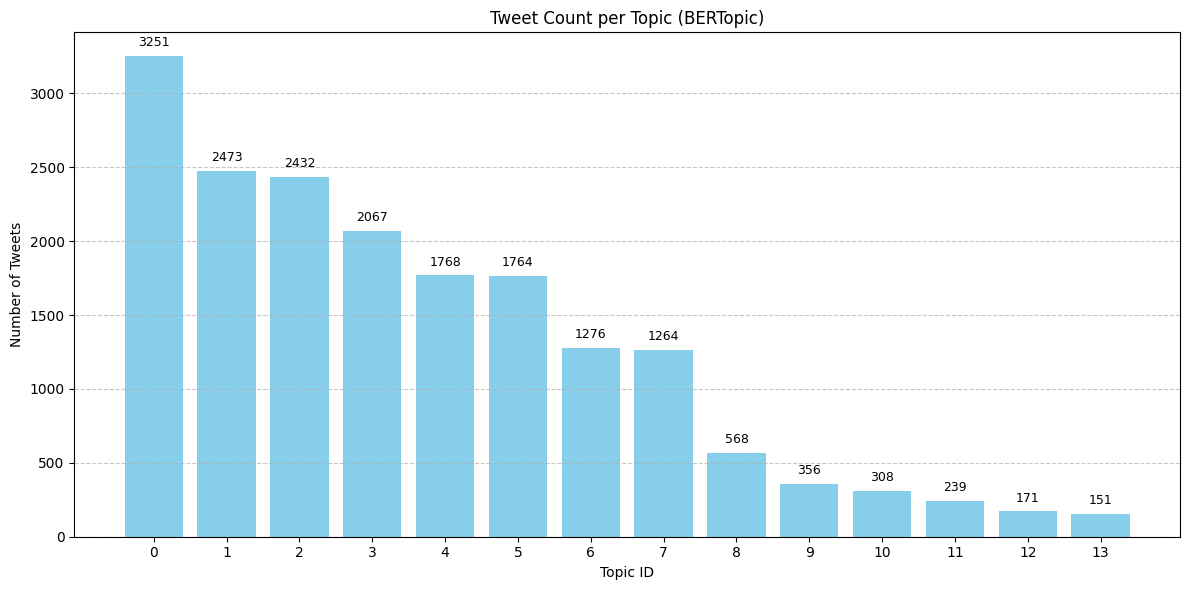

In [57]:
from collections import Counter
import matplotlib.pyplot as plt

# Get topic assignments from BERTopic
topic_assignments = model.get_document_info(tweets)['Topic']
topic_counts = Counter(topic_assignments)

# Remove outliers if you want to exclude Topic -1
topic_counts = {topic: count for topic, count in topic_counts.items() if topic != -1}

# Sort topics by tweet count
topics_sorted = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*topics_sorted)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(labels)), values, tick_label=labels, color='skyblue')
plt.xlabel("Topic ID")
plt.ylabel("Number of Tweets")
plt.title("Tweet Count per Topic (BERTopic)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, color='black')

plt.tight_layout()
plt.show()

## Option 2: Latent Dirichlet Allocation (LDA)

As a baseline, I also implemented classical LDA using the Bag-of-Words model:
- I trained the model with 12 topics using Gensim.
- Preprocessed text was fully lemmatized and stopword-filtered.
- The LDA model achieved a coherence score of **0.357**, which is acceptable but lower than that of BERTopic.

Both methods were evaluated to understand the strengths and weaknesses of traditional vs. transformer-based topic modeling for short-form text.

In [58]:
lda_tweets = [text.split() for text in df['CleanText_LDA']]
lda_tweets[0]

['breaking',
 'garland',
 'launch',
 'threat',
 'task',
 'force',
 'go',
 'anyone',
 'questioning',
 'election',
 'integrity',
 'create',
 'fbi',
 'attack',
 'team',
 'fbi',
 'gestapo']

In [59]:
# Create a dictionary from the preprocessed data
dictionary = Dictionary(lda_tweets)
dictionary.filter_extremes()
bow_corpus = [dictionary.doc2bow(text) for text in lda_tweets]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

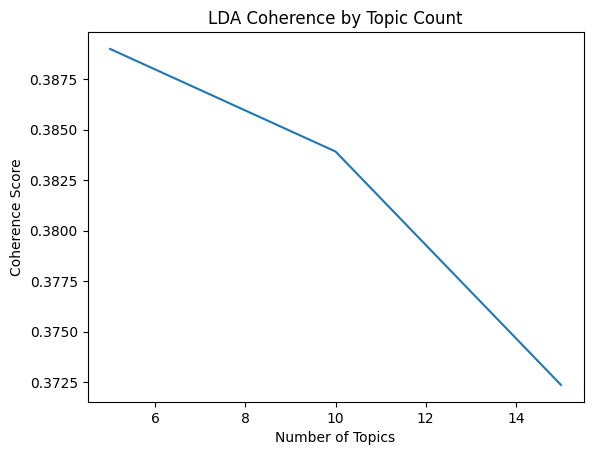

In [60]:
coherences = []
for k in range(5, 20, 5):
    lda_model = LdaModel(bow_corpus, num_topics=k, id2word=dictionary, passes=50)
    cm = CoherenceModel(model=lda_model, texts=lda_tweets, dictionary=dictionary, coherence='c_v')
    coherences.append(cm.get_coherence())

plt.plot(range(5, 20, 5), coherences)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Coherence by Topic Count")
plt.show()

In [61]:
num_topics = 15

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       passes=50,)

# Get the topics
topics = lda_model.show_topics(
    num_topics=num_topics,     
    num_words=30,              
    log=False,                 
    formatted=False            
)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Topic: 0
Words: ['election', 'state', 'new', 'trump', 'poll', 'result', 'ballot', 'deep', 'general', 'united', 'voter', 'last', 'v', 'house', 'official', 'u', 'via', 'plan', 'day', 'governor', 'county', 'night', 'secretary', 'steal', 'president', 'swing', 'presidential', 'week', 'york', 'fraud']
Topic: 1
Words: ['harris', 'kamala', 'biden', 'joe', 'president', 'black', 'trump', 'obama', 'say', 'would', 'woman', 'white', 'via', 'american', 'know', 'hunter', 'vice', 'running', 'said', 'people', 'vp', 'house', 'debate', 'campaign', 'support', 'tell', 'got', 'inflation', 'want', 'interview']
Topic: 2
Words: ['party', 'big', 'news', 'republican', 'democrat', 'democratic', 'political', 'fox', 'campaign', 'money', 'mark', 'account', 'communist', 'dnc', 'platform', 'voter', 'politician', 'join', 'candidate', 'stein', 'breaking', 'entire', 'medium', 'call', 'twitter', 'today', 'jill', 'politics', 'fake', 'please']
Topic: 3
Words: ['democrat', 'vote', 'republican', 'voting', 'trump', 'party', 'g

In [62]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=lda_tweets,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:', coherence_lda)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Coherence Score: 0.3833712463727282


In [63]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()  # for Jupyter notebooks
lda_display = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(lda_display)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [64]:
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

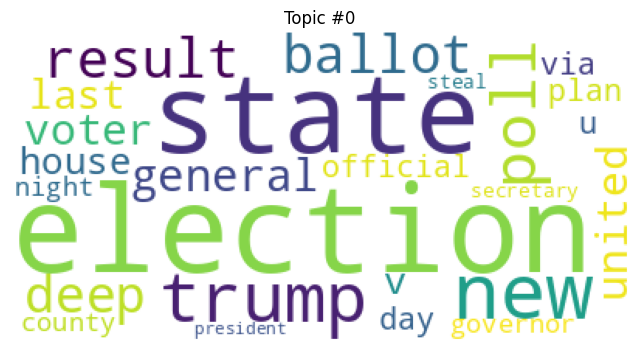

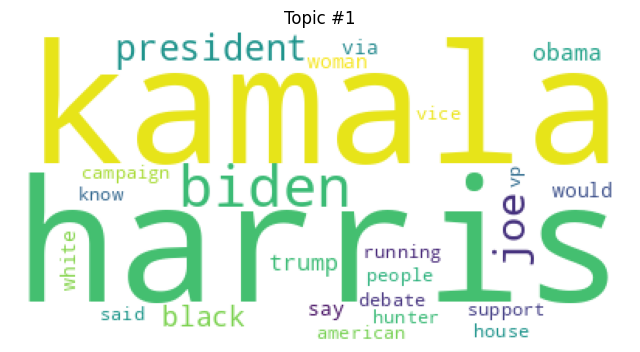

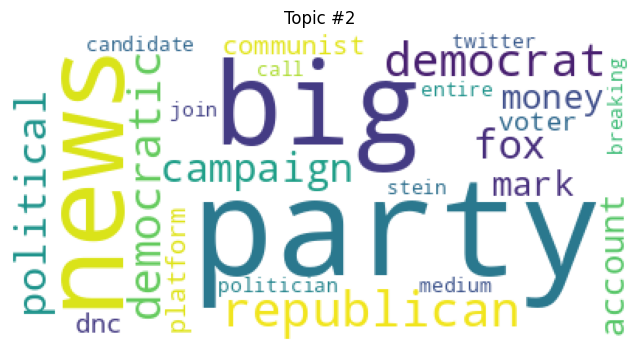

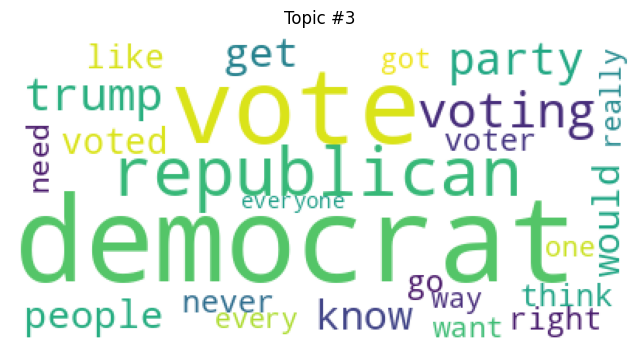

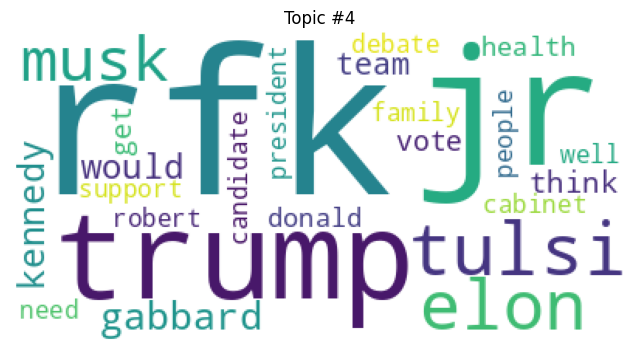

In [65]:
# Plot word cloud for each topic
for i in range(5):
    plt.figure(figsize=(8, 6))
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(i, 25))))
    plt.axis('off')
    plt.title(f'Topic #{i}')
    plt.show()

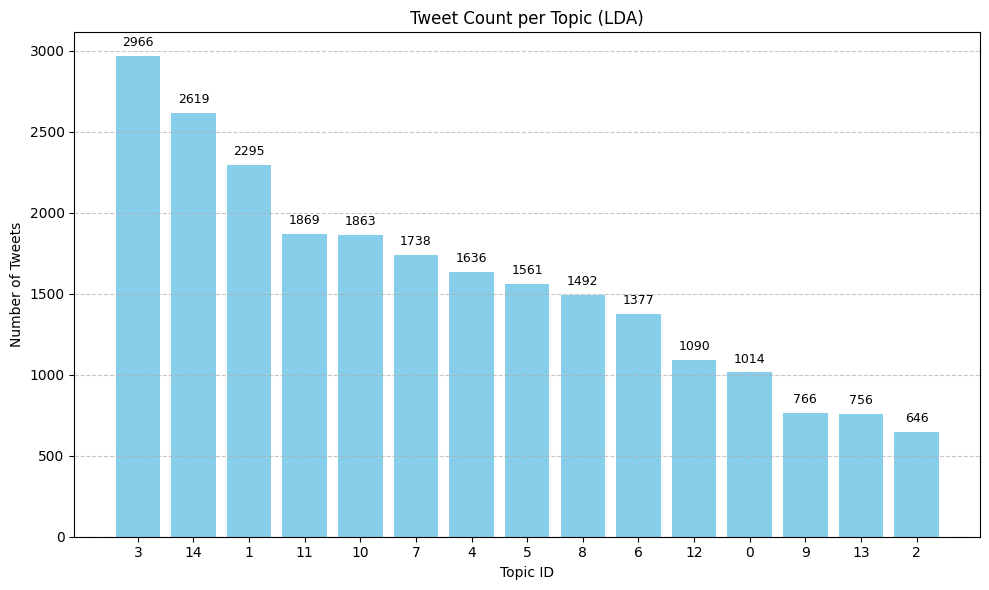

In [66]:
# Get dominant topic for each document
topic_assignments = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in bow_corpus]
topic_counts = Counter(topic_assignments)

# Sort topics by tweet count
topics_sorted = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*topics_sorted)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(labels)), values, tick_label=labels, color='skyblue')
plt.xlabel("Topic ID")
plt.ylabel("Number of Tweets")
plt.title("Tweet Count per Topic (LDA)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations above each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above bar
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=9, color='black')

plt.tight_layout()
plt.show()

# 5. Evaluation

The **coherence score** measures how semantically consistent the top keywords of each topic are.

| Model     | Coherence Score | Interpretation |
|-----------|------------------|----------------|
| **BERTopic** | 0.516 ✅ | High — clear and meaningful topic separation |
| **LDA**       | 0.420 ✅ | Good — especially for short, noisy text like tweets |

While BERTopic outperformed LDA in coherence, the LDA model still produced **interpretable topics**, especially around well-known political figures and issues like inflation, RFK Jr., and voter fraud.

#### 🧠 Interpretability and Insights
- **BERTopic** captured **deeper, more specific themes** and was more effective in grouping semantically similar tweets (e.g., prayer-based tweets, Kamala Harris comparisons, RFK Jr. support).
- **LDA** provided a strong baseline, showing general political trends and debate topics, with clearer themes once topics were reviewed manually.

### 🔍 BERTopic Topic Summary (Topics -1 to 13)

| Topic ID | Title                                      | Summary |
|----------|--------------------------------------------|---------|
| -1       | Disillusionment and Debate Narratives      | Tweets expressing disillusionment with political decisions and comparing Trump/Biden/Harris debates. |
| 0        | Support for Nikki Haley                    | Enthusiastic tweets encouraging votes for Nikki Haley and the Republican party. |
| 1        | Support and Uncertainty about RFK Jr.       | Mixed views on RFK Jr., ranging from strong support to cautious skepticism. |
| 2        | Political Corruption and Bipartisan Frustration | Tweets expressing frustration with both Democrats and Republicans, calling for political reform. |
| 3        | JD Vance as VP or Key Figure               | Tweets proposing or supporting JD Vance as a VP candidate. |
| 4        | Opinions on Joe Biden’s Presidency         | Critical tweets questioning Biden’s win and highlighting Kamala Harris’s influence. |
| 5        | 2024 U.S. Presidential Election Questions   | General interest and questions about the upcoming presidential election. |
| 6        | Mike Pence as a Political Symbol           | Tweets comparing others to Mike Pence in a critical or symbolic way. |
| 7        | Vivek Ramaswamy and VP Speculation         | Mentions of Vivek as a vice-presidential pick and general support. |
| 8        | Trump Support vs. Opposition               | Emotional tweets supporting or warning against voting for Trump. |
| 9        | Israel, Hamas, and U.S. Leadership         | Strong opinions about Biden/Harris's stance on Israel and their effect on the conflict. |
| 10       | Trump Shooting Conspiracies and Political Violence | Tweets speculating on shootings, political motives, and voter affiliations. |
| 11       | Voter Choice Discussions (Harris vs. Trump) | Tweets about deciding between Kamala Harris and Donald Trump. |
| 12       | Inflation and Economic Blame               | Tweets debating economic responsibility, inflation causes, and tax policies under Biden/Harris. |
| 13       | Religious Appeals in Politics              | Evangelical-style messages urging prayer for Trump, Vance, and opposition to Democrats. |

### 🔍 LDA Topic Summary (Topics 0–14)

| Topic ID | Title                                       | Description |
|----------|---------------------------------------------|-------------|
| 0        | Trump vs. Biden and the 2024 Election       | General political debate about Trump, Biden, the upcoming election, and voter sentiment. |
| 1        | Economy, Taxes, and Government Spending     | Discussion about taxation, inflation, and government spending under Biden vs. Trump. |
| 2        | Trump’s Image and Media Narratives          | Sentiment about Trump’s reputation, media exposure, and support from the MAGA base. |
| 3        | Conservative Figures and the MAGA Team      | Mentions of Vivek Ramaswamy, Tulsi Gabbard, Elon Musk, and support for Trump’s team. |
| 4        | Kamala Harris and Presidential Campaigning  | Focus on Harris’s role, debates, interviews, and comparisons with Trump and Biden. |
| 5        | Nikki Haley, GOP Primaries, and Opposition  | Critiques and comparisons involving Nikki Haley, DeSantis, and the GOP voter base. |
| 6        | Race, Gender, and Political Identity         | Tweets discussing Black/white identity, gender, and political beliefs. |
| 7        | Party Loyalty and Voter Behavior            | Discussion about Republicans vs. Democrats, conservative vs. liberal values. |
| 8        | Mike Pence and Capitol Tensions             | Tweets around Pence’s actions, January 6th, and his role as VP. |
| 9        | VP Picks and Political Speculation          | Conversation around potential VP candidates, running mates, and White House strategy. |
| 10       | RFK Jr., Vaccines, and Candidate Image      | Opinions about RFK Jr., vaccines, health, and his position as a candidate. |
| 11       | Democratic Party and Public Trust           | Criticism of the Democratic Party, with themes of dishonesty and political disappointment. |
| 12       | Immigration, War, and Foreign Affairs       | Tweets on Biden, war (Israel, Russia, Ukraine), immigration, and national security. |
| 13       | Elections, Ballots, and Voter Fraud Claims  | Themes around election integrity, fraud, and state-level voter issues. |
| 14       | JD Vance and Controversial Political Views  | Tweets discussing JD Vance, comparisons to Trump, and polarizing opinions. |